In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/60k-stack-overflow-questions-with-quality-rate/valid.csv
/kaggle/input/60k-stack-overflow-questions-with-quality-rate/train.csv


In [2]:
!pip install datasets


In [3]:
import pandas as pd
import re
import torch
import os
from bs4 import BeautifulSoup
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from datasets import Dataset
from tqdm import tqdm

In [4]:
# Load DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

# Load data
df_train = pd.read_csv('/kaggle/input/60k-stack-overflow-questions-with-quality-rate/train.csv')
df_valid = pd.read_csv('/kaggle/input/60k-stack-overflow-questions-with-quality-rate/valid.csv')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Preprocess data
df_train = df_train.filter(['Title', 'Body', 'Tags', 'Y'])
df_train['Y'] = df_train['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})

df_valid = df_valid.filter(['Title', 'Body', 'Tags', 'Y'])
df_valid['Y'] = df_valid['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})

In [6]:
# Preprocess data
class Preprocessing:
    def __get_body_tag_text(self, text):
        soup = BeautifulSoup(text, features='xml')
        return soup.get_text()

    def __lower_and_punc_removal(self, text):
        text = text.lower()
        text = re.sub(r'[^(a-zA-Z)\s]', '', text)
        return text

    def __init__(self, df):
        self.df = df
        self.df['Body_Between_Tags'] = self.df['Body'].apply(self.__get_body_tag_text)
        self.df['Final_clean'] = self.df['Body_Between_Tags'].apply(self.__lower_and_punc_removal)

PreprocessedObject_train = Preprocessing(df=df_train)
PreprocessedObject_valid = Preprocessing(df=df_valid)

PreprocessedObject_train.df.dropna(inplace=True)
PreprocessedObject_valid.df.dropna(inplace=True)
PreprocessedObject_train.df.reset_index(inplace=True)
PreprocessedObject_valid.df.reset_index(inplace=True)

df_train_final = PreprocessedObject_train.df
df_valid_final = PreprocessedObject_valid.df

df_train_final.drop(['index', 'Tags', 'Body', 'Title'], inplace=True, axis=1)
df_valid_final.drop(['index', 'Tags', 'Body', 'Title'], inplace=True, axis=1)

# Retain the label column
df_train_final = df_train_final[['Final_clean', 'Y']]
df_valid_final = df_valid_final[['Final_clean', 'Y']]

/tmp/ipykernel_34/447485124.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, features='xml')
/tmp/ipykernel_34/447485124.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, features='xml')


In [7]:
df_train_final.head()

,Final_clean,Y
0,im already familiar with repeating tasks every...,0
1,id like to understand why java optionals were...,2
2,i am attempting to overlay a title over an ima...,2
3,the question is very simple but i just could n...,2
4,im using custom floatingactionmenu i need to i...,2


In [8]:
'''
def collate_fn(batch):
    # Get input_ids and attention_mask tensors
    input_ids = [torch.tensor(example["input_ids"]) for example in batch]
    attention_mask = [torch.tensor(example["attention_mask"]) for example in batch]

    # Pad each sequence to the maximum length
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)  # Assuming you have attention masks

    # Check if "labels" key exists in examples
    if "labels" in batch[0] and batch[0]["labels"] is not None:
        labels = torch.tensor([example["labels"] for example in batch])
    else:
        labels = None  # Set labels to None if not present

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

'''
def collate_fn(batch):
    # Get input_ids and attention_mask tensors
    input_ids = [torch.tensor(example["input_ids"]) for example in batch]
    attention_mask = [torch.tensor(example["attention_mask"]) for example in batch]

    # Pad each sequence to the maximum length
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)  # Assuming you have attention masks

    # Check if "labels" key exists in examples
    if "labels" in batch[0] and batch[0]["labels"] is not None:
        labels = torch.tensor([example["labels"] for example in batch])
    else:
        labels = None  # Set labels to None if not present

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }



In [9]:
# Define max_seq_length
max_seq_length = 128
def tokenize_function(example):
    # Tokenize the text
    tokenized_inputs = tokenizer(example['Final_clean'], padding="max_length", truncation=True, max_length=max_seq_length)
    return tokenized_inputs

# Tokenize datasets
tokenized_datasets_train = df_train_final.apply(tokenize_function, axis=1)
tokenized_datasets_valid = df_valid_final.apply(tokenize_function, axis=1)

# Convert tokenized datasets into dictionaries of lists
tokenized_datasets_train_dict = {"input_ids": [], "attention_mask": [], "labels": []}
for tokenized_data, label in zip(tokenized_datasets_train, df_train_final['Y']):
    tokenized_datasets_train_dict["input_ids"].append(tokenized_data["input_ids"])
    tokenized_datasets_train_dict["attention_mask"].append(tokenized_data["attention_mask"])
    tokenized_datasets_train_dict["labels"].append(label)

tokenized_datasets_valid_dict = {"input_ids": [], "attention_mask": [], "labels": []}
for tokenized_data, label in zip(tokenized_datasets_valid, df_valid_final['Y']):
    tokenized_datasets_valid_dict["input_ids"].append(tokenized_data["input_ids"])
    tokenized_datasets_valid_dict["attention_mask"].append(tokenized_data["attention_mask"])
    tokenized_datasets_valid_dict["labels"].append(label)

# Convert tokenized datasets into datasets
train_dataset = Dataset.from_dict(tokenized_datasets_train_dict)
valid_dataset = Dataset.from_dict(tokenized_datasets_valid_dict)

In [10]:
# Define collate function
def collate_fn(batch):
    input_ids = pad_sequence([torch.tensor(example["input_ids"]) for example in batch], batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = pad_sequence([torch.tensor(example["attention_mask"]) for example in batch], batch_first=True, padding_value=0)
    labels = torch.tensor([example["labels"] for example in batch])
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=4, collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=4, collate_fn=collate_fn)

# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [11]:
# Define optimizer and scheduler
from transformers import AdamW, get_scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
!pip install tqdm


In [13]:
# Fine-tuning loop
from tqdm import tqdm
import torch

num_training_steps = 1  # Adjust as needed
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

model.train()

# Progress bar for the training loop
for epoch in range(num_training_steps):
    print(f"Epoch {epoch+1}/{num_training_steps}")
    epoch_iterator = tqdm(train_dataloader, desc="Training", leave=True)
    for batch in epoch_iterator:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Update progress bar with loss value
        epoch_iterator.set_postfix(loss=loss.item())


Epoch 1/1


Training: 100%|██████████| 11250/11250 [07:34<00:00, 24.75it/s, loss=0.296]  


In [14]:
# Evaluation
correct = 0
total = 0
model.eval()
for batch in valid_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    correct += torch.sum(predictions == batch["labels"]).item()
    total += len(predictions)

accuracy = correct / total
print("Accuracy:", accuracy)

Accuracy: 0.8137333333333333


In [16]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.1 MB/s eta 0:00:00a 0:00:01


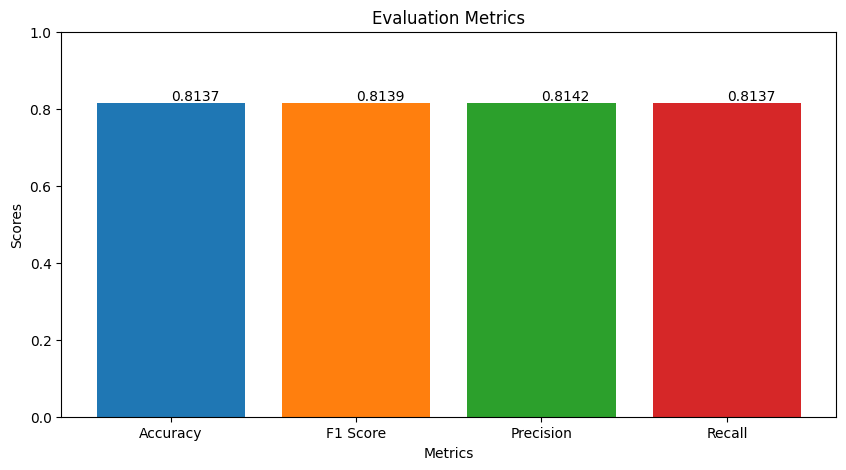

In [22]:
import evaluate
import matplotlib.pyplot as plt

# Initialize the metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

model.eval()

# Evaluate the model on the evaluation dataset
for batch in valid_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    # Add batch results to the metrics
    accuracy_metric.add_batch(predictions=predictions, references=batch["labels"])
    f1_metric.add_batch(predictions=predictions, references=batch["labels"])
    precision_metric.add_batch(predictions=predictions, references=batch["labels"])
    recall_metric.add_batch(predictions=predictions, references=batch["labels"])

# Compute the metrics
accuracy = accuracy_metric.compute()['accuracy']
f1 = f1_metric.compute(average='weighted')['f1']
precision = precision_metric.compute(average='weighted')['precision']
recall = recall_metric.compute(average='weighted')['recall']

# Store the metrics in a dictionary for easy plotting
metrics = {
    'Accuracy': accuracy,
    'F1 Score': f1,
    'Precision': precision,
    'Recall': recall
}

# Colors for the bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # You can customize these colors

# Plot the metrics as a bar chart
plt.figure(figsize=(10, 5))
bars = plt.bar(metrics.keys(), metrics.values(), color=colors)
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Evaluation Metrics')
plt.ylim(0, 1)  # Assuming metrics are between 0 and 1

# Add values on top of the bars for better visualization
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), va='bottom')  # va: vertical alignment

plt.show()


In [23]:
import pandas as pd

# Metrics data
metrics_data = {
    'Metric': ['Accuracy', 'F1 Score', 'Precision', 'Recall'],
    'Score': [accuracy, f1, precision, recall]
}

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV in Kaggle environment
metrics_df.to_csv('metrics_distilbert.csv', index=False)

# Download the CSV file to your local machine
from IPython.display import FileLink
FileLink(r'metrics_distilbert.csv')


/kaggle/working/metrics_distilbert.csv

In [25]:
import json

# Assuming `metrics` is a dictionary containing your metrics
metrics = {
    'Accuracy': accuracy,
    'F1 Score': f1,
    'Precision': precision,
    'Recall': recall
}

# Save the metrics to a JSON file in Kaggle environment
metrics_filename = 'metrics_distilbert.json'
with open(metrics_filename, 'w') as f:
    json.dump(metrics, f)

# Download the JSON file to your local machine
from IPython.display import FileLink
FileLink(r'metrics_distilbert.json')


/kaggle/working/metrics_distilbert.json

In [26]:
import torch

# Assuming `model` is your trained model
# Save the model's state dictionary to a file in Kaggle environment
model_path = 'trained_model_distilbert.pth'
torch.save(model.state_dict(), model_path)

# Download the model file to your local machine
from IPython.display import FileLink
FileLink(r'trained_model_distilbert.pth')


/kaggle/working/trained_model_distilbert.pth

In [37]:
!pip install gradio

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 85.9 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 99.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.4/121.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 9.8 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl size=5584 sha256=ccf880628f9304d2d62d15171a150422baa1c4035e564e3e8e29dacc7045c202
  Stored in directory: /root/.cache/pip/wheels/bd/65/9a/671fc6dcde07d4418df0c592f8df512b26d7a0029c2a23dd81
Successfully built ffmpy
  Attempting uninstall: websockets
    Found existing installation: websockets 12.0
    Uninstalling websockets-12.0:
      Successfully uninstalled websockets-12.0
  Attempting uninst

In [39]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer
import gradio as gr

# Load the model architecture
model = BertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)  # Adjust num_labels based on your task

# Load the saved weights
model_path = '/kaggle/working/trained_model_distilbert.pth'

# Load state_dict and check for missing keys
state_dict = torch.load(model_path, map_location=torch.device("cpu"))
missing_keys = []
for key in list(state_dict.keys()):
    if key not in model.state_dict():
        missing_keys.append(key)
        state_dict.pop(key)

if missing_keys:
    print(f"Warning: Missing keys in state_dict: {missing_keys}")

# Load the state_dict into the model
model.load_state_dict(state_dict, strict=False)

# Tokenizer for preprocessing input
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased')

# Define a function to make predictions
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return predicted_class

# Create a Gradio interface
iface = gr.Interface(
    fn=predict,
    inputs=gr.Textbox(lines=2, label="Input Text"),
    outputs=gr.Label(num_top_classes=3),
    title="DistilBERT Text Classification",
    description="Enter text to classify into one of three categories.",
)

# Launch the interface
iface.launch()


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'enc

Running on local URL:  http://127.0.0.1:7860
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Running on public URL: https://91f59b2d5045db0346.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
